# Vehicle Price Prediction

## Libraries

In [2]:
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

## Reading the Data

In [3]:
dataset = pd.read_csv('car data.csv')
dataset.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


### Understanding the Data - Feature Engineering

- **Target Variable** : Selling_Price
- **Categorical Features** :
    - Fuel_Type
    - Seller_Type
    - Transmission
    - Owner
- **Quantitative Features** :
    - Year
    - Present_Price
    - Kms_Driven
    
Removing `Car_Name`, since it won't be contributing to the model.

In [4]:
dataset.dtypes

Car_Name          object
Year               int64
Selling_Price    float64
Present_Price    float64
Kms_Driven         int64
Fuel_Type         object
Seller_Type       object
Transmission      object
Owner              int64
dtype: object

#### Unique values of categorical features

In [5]:
dataset['Seller_Type'].unique()

array(['Dealer', 'Individual'], dtype=object)

In [6]:
dataset['Fuel_Type'].unique()

array(['Petrol', 'Diesel', 'CNG'], dtype=object)

In [7]:
dataset['Transmission'].unique()

array(['Manual', 'Automatic'], dtype=object)

In [8]:
dataset['Owner'].unique()

array([0, 1, 3], dtype=int64)

#### Check Missing or Null Values

In [10]:
dataset.isnull().sum()

Car_Name         0
Year             0
Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
dtype: int64

**NOTE** - No missing values observed

In [9]:
dataset.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

In [10]:
filter_data = dataset[['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']]
filter_data.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


#### Derived Feature (Year -> No. Of Years)

In [11]:
# Assuming `current_year` as 2022

current_year = 2022
filter_data['Num_Year'] = current_year - filter_data['Year']

In [13]:
filter_data.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Num_Year
0,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0,8
1,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0,9
2,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0,5
3,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0,11
4,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0,8


In [14]:
filter_data.drop(columns='Year', inplace=True)
filter_data.head()

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Num_Year
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,8
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,9
2,7.25,9.85,6900,Petrol,Dealer,Manual,0,5
3,2.85,4.15,5200,Petrol,Dealer,Manual,0,11
4,4.60,6.87,42450,Diesel,Dealer,Manual,0,8


### Representation of Categorical Features

- We are creating dummy columns for each of the categorical features. These columns are created for each of the category value, and would be assigned 1 or 0, depending on which record contains it or not.
- We are using `drop_first=True` flag, to skip the first category from the list of categories for each of the categorical feature. We are doing this to save it from the `Dummy Variable Trap`

In [15]:
filter_data = pd.get_dummies(filter_data, drop_first = True)
filter_data.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Num_Year,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,8,False,True,False,True
1,4.75,9.54,43000,0,9,True,False,False,True
2,7.25,9.85,6900,0,5,False,True,False,True
3,2.85,4.15,5200,0,11,False,True,False,True
4,4.60,6.87,42450,0,8,True,False,False,True


### Correlation of Features

In [16]:
data_corr = filter_data.corr()
data_corr

,Selling_Price,Present_Price,Kms_Driven,Owner,Num_Year,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
Selling_Price,1.000000,0.878983,0.029187,-0.088344,-0.236141,0.552339,-0.540571,-0.550724,-0.367128
Present_Price,0.878983,1.000000,0.203647,0.008057,0.047584,0.473306,-0.465244,-0.512030,-0.348715
Kms_Driven,0.029187,0.203647,1.000000,0.089216,0.524342,0.172515,-0.172874,-0.101419,-0.162510
Owner,-0.088344,0.008057,0.089216,1.000000,0.182104,-0.053469,0.055687,0.124269,-0.050316
Num_Year,-0.236141,0.047584,0.524342,0.182104,1.000000,-0.064315,0.059959,0.039896,-0.000394
Fuel_Type_Diesel,0.552339,0.473306,0.172515,-0.053469,-0.064315,1.000000,-0.979648,-0.350467,-0.098643
Fuel_Type_Petrol,-0.540571,-0.465244,-0.172874,0.055687,0.059959,-0.979648,1.000000,0.358321,0.091013
Seller_Type_Individual,-0.550724,-0.512030,-0.101419,0.124269,0.039896,-0.350467,0.358321,1.000000,0.063240
Transmission_Manual,-0.367128,-0.348715,-0.162510,-0.050316,-0.000394,-0.098643,0.091013,0.063240,1.000000


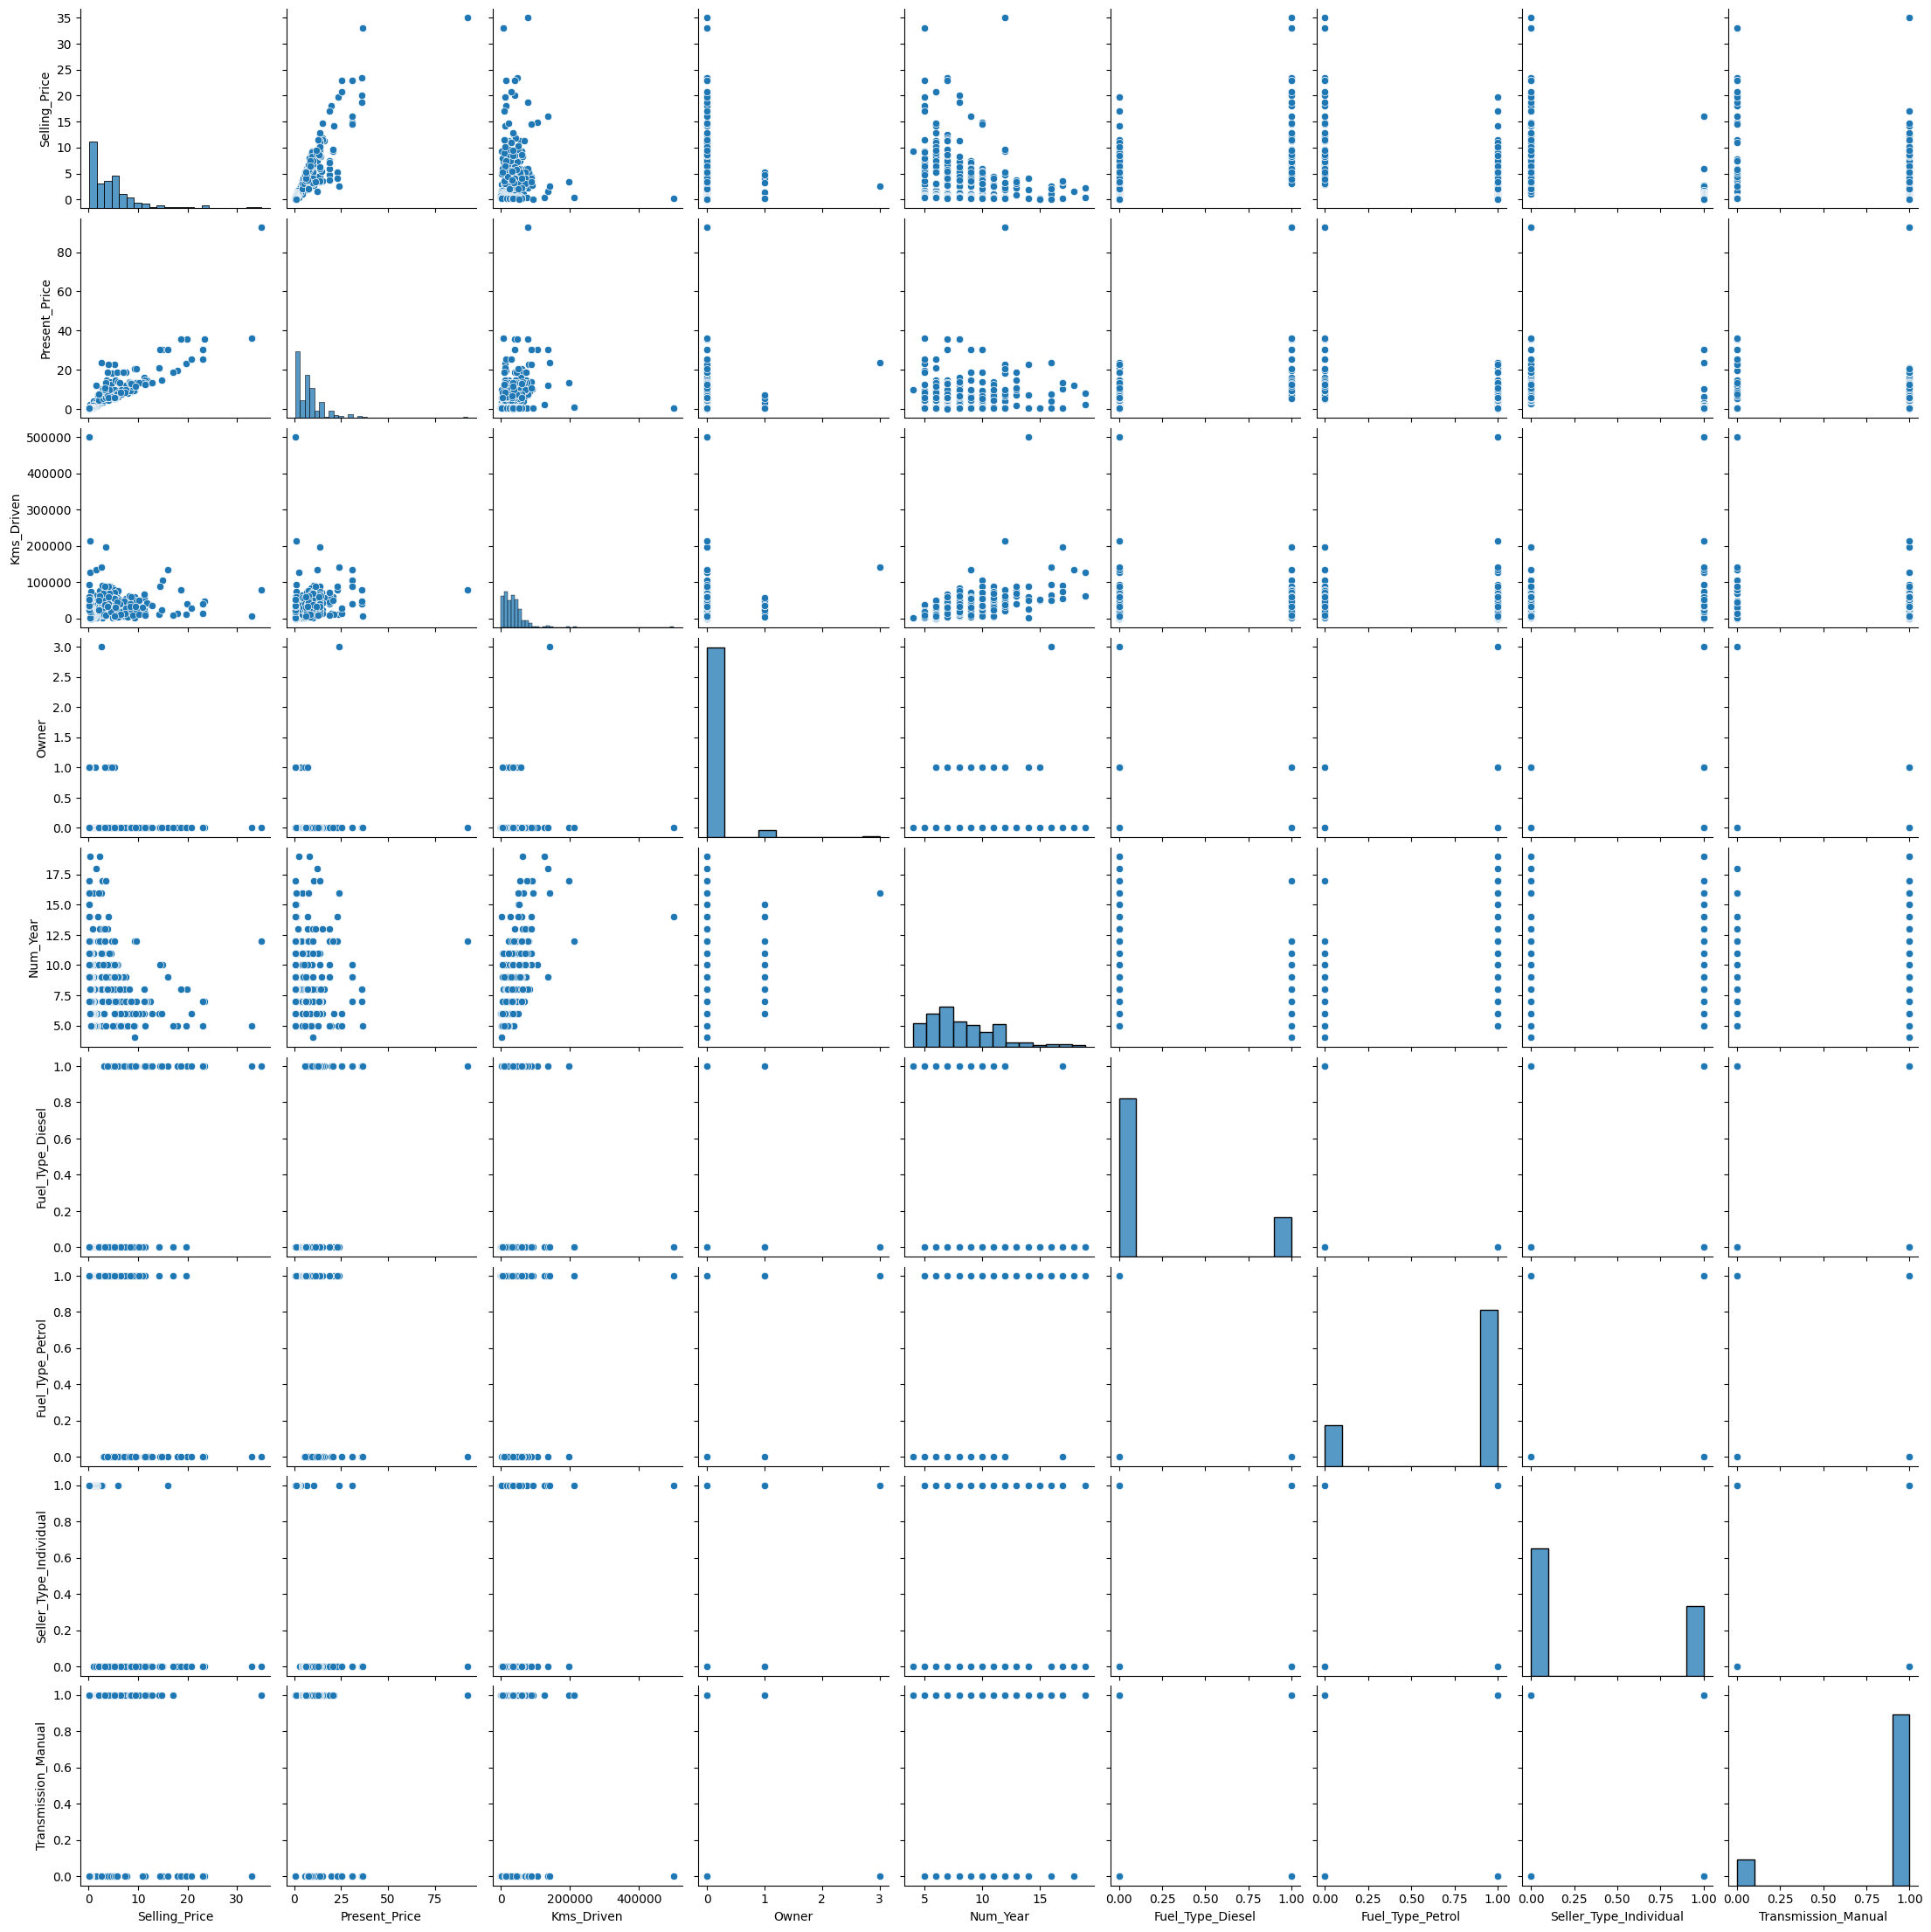

In [17]:
sns.pairplot(filter_data)

<Axes: >

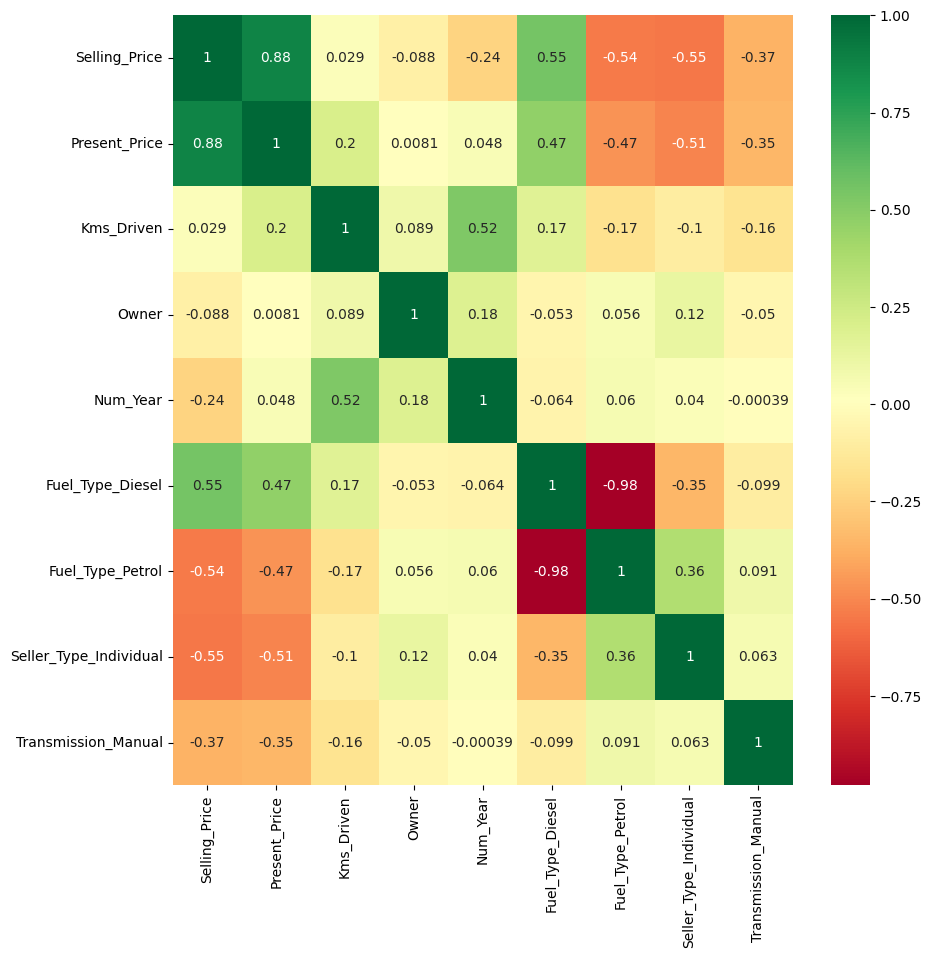

In [18]:
plt.figure(figsize=(10,10))
sns.heatmap(data_corr, annot=True, cmap = 'RdYlGn')

### Assigning Independent and Dependent variables

In [19]:
X = filter_data.iloc[:, 1:]
y = filter_data.iloc[:, 0]

In [20]:
X.head()

,Present_Price,Kms_Driven,Owner,Num_Year,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,5.59,27000,0,8,False,True,False,True
1,9.54,43000,0,9,True,False,False,True
2,9.85,6900,0,5,False,True,False,True
3,4.15,5200,0,11,False,True,False,True
4,6.87,42450,0,8,True,False,False,True


In [21]:
y.head()

0    3.35
1    4.75
2    7.25
3    2.85
4    4.60
Name: Selling_Price, dtype: float64

### Feature Importance

In [22]:
model = ExtraTreesRegressor()
model.fit(X, y)

ExtraTreesRegressor()

In [23]:
model.feature_importances_

array([0.39534836, 0.04269207, 0.00081071, 0.0763985 , 0.21921566,
       0.01371257, 0.11871321, 0.13310892])

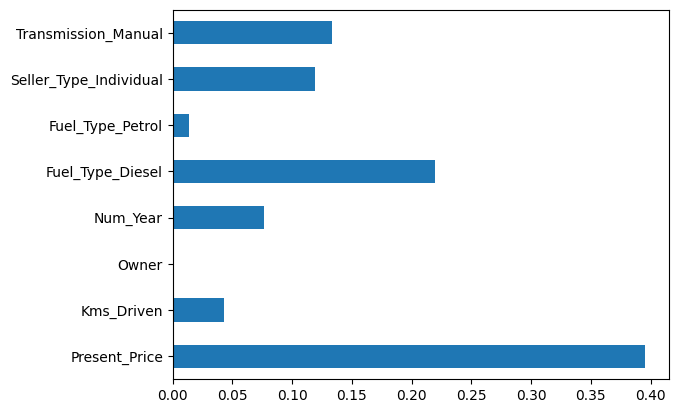

In [24]:
feature_importances = pd.Series(model.feature_importances_, index = X.columns)
feature_importances.plot(kind='barh')
plt.show()

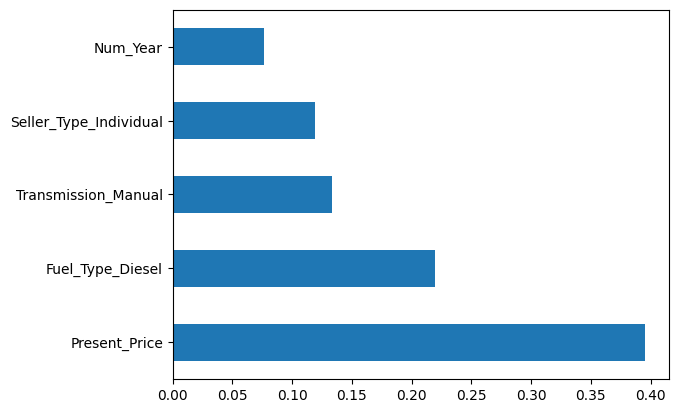

In [25]:
feature_importances.nlargest(5).plot(kind='barh')
plt.show()

## Train Test Split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 20% -> Test

## Model Initialization

We are going to use random forest regressor. Since it is based on decision trees, and generally decision trees do not require scaling of the values, we will not be scaling the values in this case.

In [27]:
model_rf = RandomForestRegressor()

### Hyperparameters

In [28]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=100, stop=1200, num = 12)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num=6)]

# Minimum number of samples required to split a node
min_samples_split = [2,5,10,15,100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1,2,5,10]

In [30]:
# Random Grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}
random_grid

{'n_estimators': [100,
  200,
  300,
  400,
  500,
  600,
  700,
  800,
  900,
  1000,
  1100,
  1200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 10, 15, 20, 25, 30],
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10]}

Applying RandomizedSearchCV to get the optimum values for each of the hyper-parameters mentioned above.

In [31]:
rscv = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, scoring = 'neg_mean_squared_error', n_iter = 10, cv = 5, verbose = 2, random_state = 42, n_jobs = 1)

## Model Training

In [39]:
rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   1.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   2.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   2.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

## Prediction

In [33]:
predictions = rscv.predict(X_test)
predictions

array([ 0.44238,  9.54425,  5.3854 ,  0.53079,  5.2906 ,  0.32811,
        6.59792,  1.18132,  6.64325,  0.84443,  4.93675,  4.8405 ,
       11.71525, 11.79553,  2.59587,  4.87669,  6.80752,  2.97579,
        6.80242,  5.41177,  5.32595,  0.97761, 10.68228,  0.65034,
       17.22292,  5.44434,  0.46605,  5.82773,  7.3654 ,  3.6738 ,
        4.87081,  3.48266,  0.62722,  0.65521,  3.18172,  2.22179,
        0.81415, 19.49442,  6.86988,  0.73356,  1.26145,  4.30436,
        0.50352,  5.2061 ,  0.50368,  5.67025,  0.53103,  6.0373 ,
        0.67795,  4.10624,  0.59879,  2.86388,  0.99329,  0.7876 ,
        6.7402 ,  4.91172,  1.08071,  8.52038,  2.93213,  4.47553,
        3.94518])

### Visualizing the predictions against actual data

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_18016\3182638411.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test - predictions)


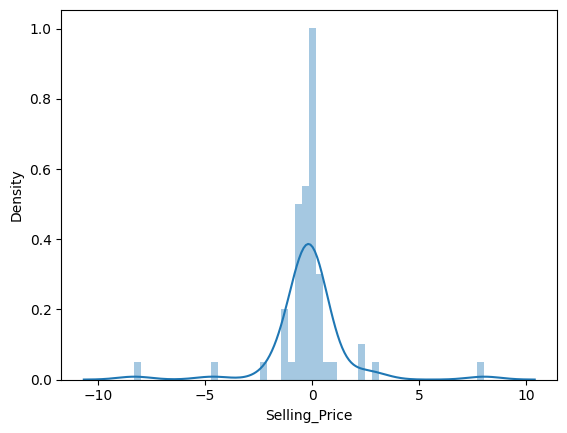

In [34]:
sns.distplot(y_test - predictions)
plt.savefig('visualize_predicted_dist')

The plot looks is that of a Gaussian Distribution. A thinner distribution plot, would mean that our predictions are closer to the actual test data.

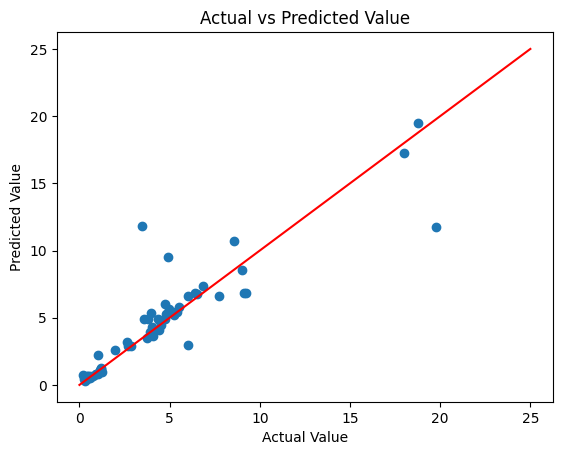

In [36]:
plt.scatter(y_test, predictions)
plt.plot((0,25), (0,25), c='r')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual vs Predicted Value')
plt.savefig('visualize_predicted_scatter')
plt.show()

Here we can see that the scatter plot, almost aligns with the `y=1` line. This means that the predicted values are close to actual values.

## Pickle the File

Serialise the file, so that this can be deployed.

In [37]:
# Open a file, where we want to store the data
file = open('rf_model.pkl', 'wb') # Write bytes mode

# dump information to that file
pickle.dump(rscv, file)

In [38]:
file.close() # If we do not do this, then we won't be able to read this model in any application